# Import Dependencies

In [2]:
import warnings                                  # `do not disturb`
warnings.filterwarnings('ignore')

import numpy as np                               # vectors and matrices
import pandas as pd                              # tables and data manipulations
import matplotlib.pyplot as plt                  # plots
import seaborn as sns                            # more plots

from dateutil.relativedelta import relativedelta # working with dates with style
from scipy.optimize import minimize              # for function minimization

import statsmodels.formula.api as smf            # statistics and econometrics
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs

from itertools import product                    # some useful functions
from tqdm import tqdm_notebook
import pickle
%matplotlib inline

In [ ]:
# For bitcoin only

In [3]:
with open("./data/btc.pickle", 'rb') as f:
    btc = pickle.load(f)

In [5]:
btc.head()

,Asset_ID,Count,Open,High,Low,Close,Volume,VWAP,Target
timestamp,,,,,,,,,
1514764860,1,229.0,13835.194,14013.8,13666.11,13850.176,31.550062,13827.062093,-0.014643
1514764920,1,235.0,13835.036,14052.3,13680.00,13828.102,31.046432,13840.362591,-0.015037
1514764980,1,528.0,13823.900,14000.4,13601.00,13801.314,55.061820,13806.068014,-0.010309
1514765040,1,435.0,13802.512,13999.0,13576.28,13768.040,38.780529,13783.598101,-0.008999
1514765100,1,742.0,13766.000,13955.9,13554.44,13724.914,108.501637,13735.586842,-0.008079


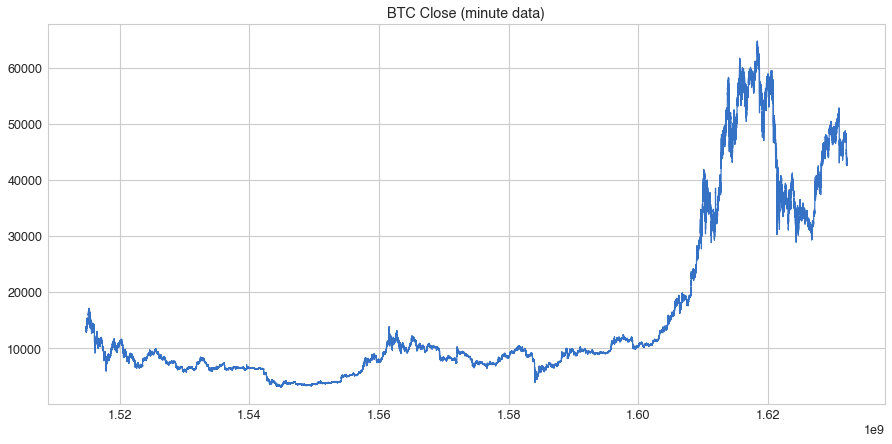

In [7]:
plt.figure(figsize=(15, 7))
plt.plot(btc.Close)
plt.title('BTC Close (minute data)')
plt.grid(True)
plt.show()

# Forecast Quality Metrics


In [8]:
# Importing metrics

from sklearn.metrics import r2_score, median_absolute_error, mean_absolute_error
from sklearn.metrics import median_absolute_error, mean_squared_error, mean_squared_log_error

def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# Move, smoothe, evaluate